## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [162]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm

%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [163]:
# read the dataset and inspect
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [164]:
# to see number of rows
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [165]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [166]:
df['converted'].mean() 

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [167]:
pd.crosstab(df.group, df.landing_page, margins=True)

landing_page,new_page,old_page,All
group,,,
control,1928,145274,147202
treatment,145311,1965,147276
All,147239,147239,294478


The number of times where 'new_page' and 'treatment' don't line up is 1928 + 1965 = 3893

f. Do any of the rows have missing values?

In [168]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no missing Values in the dataset

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [169]:
df2 = df[((df['group']=='treatment') & (df['landing_page']=='new_page')) | ((df['group']=='control') & (df['landing_page']=='old_page'))]

In [170]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [171]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [172]:

df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [173]:
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [174]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [175]:
df2.shape

(290585, 5)

In [176]:
df2 = df2.drop_duplicates(subset='user_id')

In [177]:
df2.shape

(290584, 5)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [178]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [179]:
df2.query("group == 'control'").converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [180]:
df2.query("group == 'treatment'").converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [181]:
len( df2[df2['landing_page'] == 'new_page'] ) / len(df2)

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer**: Based on the result above, the control group is higher ‘0.1203’ than the treatment group ‘0.1188’, but this doesn't provide solid evidence if one page leads to a higher converted rate.


<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer**: 
                $$H_0: p_{new} \leq p_{old}$$
                $$H_1: p_{new} > p_{old}$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [182]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [183]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [184]:
new_page_df = df2.query("landing_page == 'new_page'")
n_new = new_page_df.shape[0]
n_new

145310

d. What is $n_{old}$?

In [185]:
old_page_df = df2.query("landing_page == 'old_page'")
n_old = old_page_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [186]:
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17351

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [187]:
old_page_converted = np.random.binomial(n_old,p_old )
old_page_converted

17360

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [188]:
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)
p_diff

-9.154180567583214e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [189]:
p_diffs = []

for _ in range(10000):
    new_converted_simulation = np.random.binomial(n_new, p_new) / n_new
    old_converted_simulation = np.random.binomial(n_old, p_old) / n_old
    diff = new_converted_simulation - old_converted_simulation
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

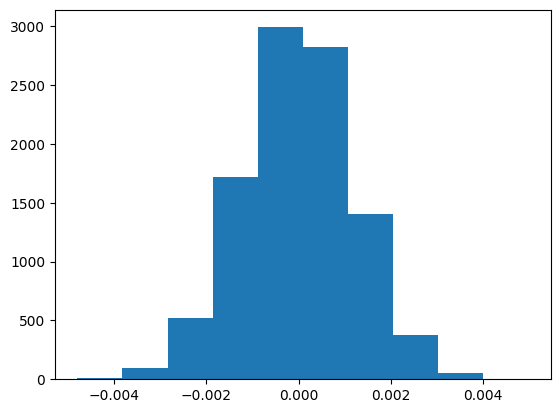

In [190]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [191]:

org_old_mean = df.query('group =="control"').converted.mean()
org_new_mean = df.query('group =="treatment"').converted.mean()
org_diff = org_new_mean - org_old_mean

p_diffs = np.array(p_diffs)

(p_diffs > org_diff).mean()

0.8855

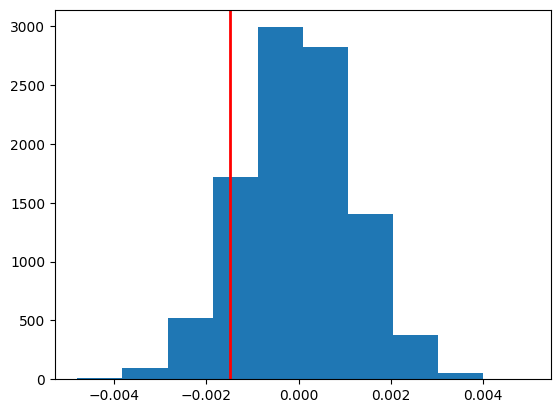

In [192]:
plt.hist(p_diffs);
plt.axvline(org_diff,c='red',linewidth = 2);

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** 
 The value above represents the p-value of observing the statistic given the Null is true. As the p-value is large enough, we would fail to reject the Null hypothesis and keep the old page.


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [193]:
import statsmodels.api as sm

df2.head(3)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [194]:
convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

print(convert_old, convert_new, n_old, n_new) 

17489 17264 145274 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [195]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')

z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [196]:
from scipy.stats import norm

In [197]:
print(norm.cdf(z_score))

0.9050583127590245


In [198]:
print(norm.ppf(1-(0.05)))

1.6448536269514722


**Answer:**

`-` We find that the z-score of 1.3116075339133115 is less than the critical value of 1.6448536269514722. So, we accept the null hypothesis.

`-` These values agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [199]:
# create dummy variables from the group column
df2[['ab_page','treatment']] = pd.get_dummies(df2['group'])
# drop the treatment column since this is not necessary
df2 = df2.drop(['treatment'], axis=1)
# create intercept column
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,True,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,True,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,False,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,False,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,True,1


In [200]:
df2["ab_page"] = df2["ab_page"].astype(int)

In [201]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [202]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  int32 
 6   intercept     290584 non-null  int64 
dtypes: int32(1), int64(3), object(3)
memory usage: 16.6+ MB


In [203]:
df2['ab_page'] = df2['ab_page'].astype(int)

In [204]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-07 00:59 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.18988    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

In [205]:
np.exp(0.0150)


1.015113064615719

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [206]:
# result = logit.fit()
# result.summary()

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:**  The p-value found in the logistic regression model(0.19) is different than what we found in parts j and k because our null and alternative hypthesis model assumed that there is an equal probability of the old and new page converting users.
In the logistic regression model, this is not the case. Also, the Logistic Regression performed is a two-tailed test, whereas the computation done in Part II is a one-tailed test.

- Our Hypothesis is:
- $H_{0}$ : $p_{new}$ - $p_{old}$  = 0
- $H_{1}$ : $p_{new}$ - $p_{old}$  != 0

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** 

The current hypotheses are too simplistic and do not account for the complexity of the conversion process. They only consider the type of page as a factor, but there may be other variables that affect the outcome. A more comprehensive model is needed to capture the nuances and interactions of different factors that influence conversion.



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

**Answer:** The country that a user is in does not affect the conversion rate. We can determine this by figuring out the conversion rate of each of the countries. US: 0.1195 UK: 0.1206 CA: 0.1153 These are approximately all the same. We fail to reject the null hypothesis.

In [207]:
df3 = pd.read_csv('countries.csv')
df3.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [208]:
# create dummy variables for country column
df3[['CA','UK', 'US']] = pd.get_dummies(df3['country'])
# Drop country, we don't need it
df3 = df3.drop(['country'], axis=1)
df3.head()

,user_id,CA,UK,US
0,834778,False,True,False
1,928468,False,False,True
2,822059,False,True,False
3,711597,False,True,False
4,710616,False,True,False


In [209]:
new_df = df2.join(df3.set_index('user_id'), on='user_id')
new_df.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,False,False,True
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,False,False,True
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,False,False,True
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,False,False,True
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,False,False,True


In [210]:
new_df["CA"] = new_df["CA"].astype(int)
new_df["UK"] = new_df["UK"].astype(int)
new_df["US"] = new_df["US"].astype(int)

In [211]:
new_df.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,0,1


In [212]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   ab_page       290584 non-null  int32 
 6   intercept     290584 non-null  int64 
 7   CA            290584 non-null  int32 
 8   UK            290584 non-null  int32 
 9   US            290584 non-null  int32 
dtypes: int32(4), int64(3), object(3)
memory usage: 20.0+ MB


In [213]:
new_df.query('US == 1').converted.mean(),new_df.query('UK == 1').converted.mean(),\
       new_df.query('CA == 1').converted.mean()

(0.1195468006423762, 0.12059448568984076, 0.11531829781364232)

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [214]:
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']
new_df['CA_ab_page'] = new_df['CA'] * new_df['ab_page']

In [215]:
log_mod = sm.Logit(new_df['converted'], new_df[['intercept', 'US_ab_page', 'UK_ab_page', 'CA_ab_page']])
results = log_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-07 00:59 AIC:              212784.0722
No. Observations:   290584           BIC:              212826.3908
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.57312    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
US_ab_page    0.0173    0.0126     1.3736  0.1696  -0.0074   0.0420
UK_ab_page    0.0115    0.0181     0.6392  0.5227  -0.0239   0.0469
CA_ab_page   -0.0002    0.0373    -0.0064  0.9949  -0.0734   0.0729
==================================================================

"""

In [216]:
logit_interaction = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'CA', 'UK_ab_page', 'CA_ab_page']])

In [217]:
result2 = logit_interaction.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Method:           MLE        
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2023-08-07 00:59 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           LLR p-value:      0.19199    
No. Iterations:     6.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0070    0.0097  -207.0454  0.0000  -2.0260  -1.9880
ab_page       0.0206    0.0137     1.5052  0.1323  -0.0062   0.0473
UK            0.0257    0.0188     1.3634  0.1728  -0.0112   0.0625
CA           -0.0644    0.0384    -1.6788  0.0932  -0.1396   0.0108
UK_ab_page   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
CA_ab_page    0.0469    0.0538     0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

In [218]:
np.exp(results.params)


intercept     0.134827
US_ab_page    1.017439
UK_ab_page    1.011611
CA_ab_page    0.999761
dtype: float64

<a id='conclusions'></a>
## Conclusions


As we see above, we may conclude there is no significant effect on the conversion based on the country.

Our analysis of the conversion rates of the new and old page revealed no significant difference between them. We applied the Z-test, logistic regression model, and actual difference observed as our statistical tests. All of them failed to reject the null hypothesis. Therefore, we advise the e-commerce company to retain the old page. This will avoid unnecessary costs and efforts on developing a new page.


## Resources


<a pd.crosstab> </a>

[pd.crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html)  

[pd.get_dummies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html)

[Python Pandas – get_dummies() method](https://www.geeksforgeeks.org/python-pandas-get_dummies-method/) 

[scipy.stats.norm](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)

[numpy.random.binomial](https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html)

[matplotlib.pyplot.axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)